##### <b> 1. 개요  </b>
음성 관련 실험을 보다 편리하게 하기 위해서 음성 관련 여러가지 시각화, 분석 기법들을 보다 전문적이고, 자신이 원하는 대로 적용시키는 데 도움을 주는 프로그램을 제작하는 프로젝트

In [ ]:
import os
import numpy as np
import matplotlib
from  matplotlib import pyplot as plt
%matplotlib qt
import scipy
import librosa
import FVA.FVA as fva
from FVA.lpc import *
from FVA.detect import *
saveresult = False

In [ ]:
def print_2dplot(x, y, xlim, ylim, xlabel, ylabel, position, xscale = 'linear', yscale = 'linear', color = 'b', lw = 1):
    plt.subplot(position[0], position[1], position[2])
    plt.plot(x, y, color=color, lw=lw)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xscale(xscale)
    plt.yscale(yscale)

#### <b> 2. Spectrum</b>
target_sounds의 첫 번째 파일을 시각화

In [ ]:
FILE_LIST = os.listdir('FVA\\target_sounds')
FILE_PATH = 'FVA\\target_sounds\\' + FILE_LIST[0]

SSA = fva.SingleSoundAnalyser(FILE_PATH = FILE_PATH, duration = 2)

print_2dplot(*SSA.get_source(),[2,1,1],color='slateblue')
print_2dplot(*SSA.get_spectrum(xlim=[1,5000],ylim=[1e-7,None]),[2,1,2],xscale='log',yscale='log',color='mediumslateblue',lw=0.5)

mng = plt.get_current_fig_manager()
#mng.full_screen_toggle()
if saveresult: plt.savefig('FVA\\results\\smalldrum_spectrum')
plt.show()

#### <b>3. Spectrogram</b>
target_sounds의 첫 번째 파일을 시각화

In [ ]:
spec_out, fout_index, pout= SSA.get_fp_stft(True, 2560, 1280, 32, 8096, 3)
print(spec_out)

In [ ]:
x = np.arange(0,  spec_out.shape[1] , 1) * SSA.df0
y = np.arange(0,  spec_out.shape[0] , 1) * SSA.dt0
X, Y = np.meshgrid(x, y)

x0=np.zeros(spec_out.shape[0] * SSA.max_num_formants)
y0=np.zeros(spec_out.shape[0] * SSA.max_num_formants)
z0=np.zeros(spec_out.shape[0] * SSA.max_num_formants)
for j in range( SSA.max_num_formants):
	for i in range( spec_out.shape[0] ):
		if fout_index[i][j] >= 0:
			x0[i + j * spec_out.shape[0]]= fout_index[i][j] * SSA.df0
			y0[i + j * spec_out.shape[0]]= SSA.dt0 * i
			z0[i + j * spec_out.shape[0]]= spec_out[i][int(fout_index[i][j])]

fig = plt.figure()
ax1 = fig.add_subplot(111,projection='3d')
ax1.view_init(elev=70,azim=310,roll=0)
ax1.set_xlabel('frequency[Hz]')
ax1.set_ylabel('time[sec]')
ax1.set_zlabel('level')
#ax1.plot_wireframe(X,Y,spec_out,alpha=0.7)
ax1.plot(x0,y0,z0,'o',color='r',ms=1,mew=5)
ax1.plot_surface(X,Y,spec_out,cmap=matplotlib.cm.coolwarm,lw=0,antialiased=False,alpha=0.4)
if saveresult: plt.savefig('FVA\\results\\smalldrum_3dformants')

fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.set_ylabel('frequency[Hz]')
ax2.set_xlabel('time[sec]')
X,Y=np.meshgrid(x,y)
ax2.pcolor(np.transpose(Y),np.transpose(X),np.transpose(spec_out))
ax2.set_yscale('log')
ax2.plot(y0, x0 , "o", color='r', ms=2.5, mew=2.5)
if saveresult: plt.savefig('FVA\\results\\smalldrum_spectrogram')

mng = plt.get_current_fig_manager()
#mng.full_screen_toggle()

plt.show()

#### <b>4. LPC(Linear Prediction Coding)</b>
target_sounds의 첫 번째 파일을 시각화

In [ ]:
def to_db(x):
  return 10 * np.log10(x)
x,y = SSA.get_spectrum()[:2]
y = to_db(y)
plt.figure(figsize=(12,8))
#plt.subplot(2,1,1)
plt.plot(x[::10],y[::10],c='lightskyblue',lw=1, alpha=1, label='FFT')
plt.xscale('log', base=10)

FreqPoints=8096
df0 = (SSA.sr / 2.) / FreqPoints
Y = SSA.fdata.copy()
Y -= np.hstack((Y[0],Y[:-1]))*0.8
windowed = np.hamming(Y.shape[0]) * Y
a, e = lpc(windowed,lpcOrder=80)
w, h = scipy.signal.freqz(np.sqrt(e), a, FreqPoints)
lpcspec = np.abs(h)
lpcspec[lpcspec < 1.] = 1.
#lpcspec *= (1./float(1 << ((8 * SSA.samplewidth)-1)))

loglpcspec = to_db(lpcspec)

bias = y.mean() - loglpcspec.mean()

#plt.subplot(2,1,2)
plt.plot(np.linspace(0,SSA.sr/2.,len(loglpcspec)), loglpcspec+bias, label='LPC', color='green')

f_result, i_result = formant_detect(lpcspec,df0,1)
plt.plot(f_result, loglpcspec[i_result] + bias, "o", c='r', label='formants', mew=4, ms=4)
plt.legend()

mng = plt.get_current_fig_manager()
#mng.full_screen_toggle()
if saveresult: plt.savefig('FVA\\results\\smalldrum_lpcspectrum')

plt.show()
print(f_result)

#### <b>5. MFCC </b>

<img src="gitar//MFCC3.png" width="50%" height="50%"></img>

_Mel 단위_

<img src="gitar//MFCC4.png" width="50%" height="50%"></img>

<img src="gitar//MFCC.png" width="50%" height="50%"></img>

_MFCC filter bank_

<img src="gitar//MFCC2.png" width="50%" height="50%"></img>

80


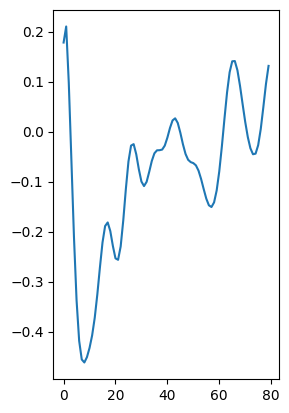

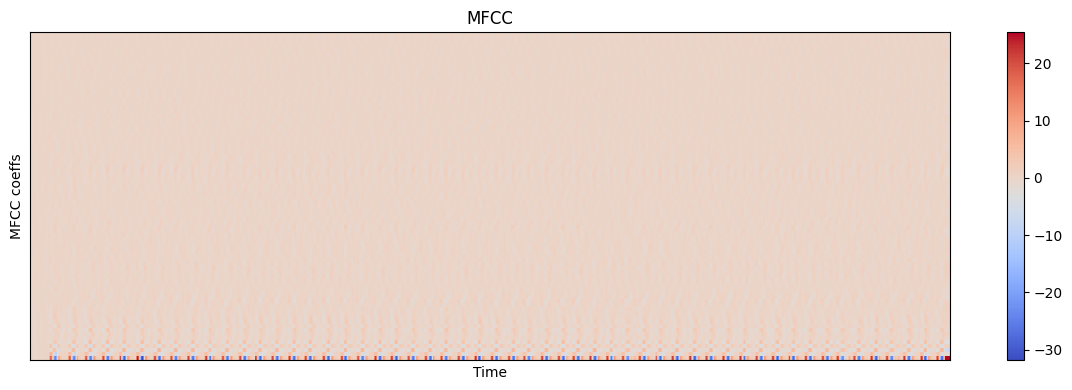

In [20]:
import matplotlib.pyplot as plt
import librosa.display
import librosa
import numpy as np

path = 'FVA//target_sounds//2023711작은탐.wav'
sample_rate=44100

x = librosa.load(path=path,sr=sample_rate)[0]
S = librosa.feature.melspectrogram(y=x, sr=sample_rate, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=80)

delta2_mfcc = librosa.feature.delta(mfcc, order=2)


plt.subplot(1,2,1)

delta2_mfcc2 = np.swapaxes(delta2_mfcc,1,0)
plt.plot(delta2_mfcc2[0])
print(len(delta2_mfcc2[0]))


plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

# 여러 파일 자동 시각화
target_sounds 내의 .wav 파일을 전부 시각화하여 그 결과를 results에 이미지 형태로 저장

#### 1. '.wav' 파일 긁어오기

In [ ]:
FILE_LIST = os.listdir('FVA\\target_sounds')
WAV_LIST = []
for name in FILE_LIST:
  if os.path.splitext(name)[1] == '.wav':
    WAV_LIST.append(name)
print(WAV_LIST)

#### 2. SingleSoundAnalyser로 '.wav' 파일 불러오기

In [ ]:
DURATION = None
SAMPLE_RATE = None
SSA_LIST = []
for name in WAV_LIST:
  SSA_LIST.append(fva.SingleSoundAnalyser('FVA\\target_sounds\\'+name, DURATION, SAMPLE_RATE))

In [ ]:
print_2dplot(*SSA_LIST[0].get_source(),[1,2,1])